# Cognitive Services Personalizer 
https://github.com/Azure-Samples/cognitive-services-personalizer-samples

This tutorial simulates a Personalizer loop _system_ which suggests which type of coffee a customer should order. The users and their preferences are stored in a [user dataset](users.json). Information about the coffee is also available in a [coffee dataset](coffee.json).

A summary of the user information is:

|Customers|Times of Day|Types of weather|
|--|--|--|
|Alice<br>Bob<br>Cathy<br>Dave|Morning<br>Afternoon<br>Evening|Sunny<br>Rainy<br>Snowy| 

To help Personalizer make the correct coffee selection for each person, the _system_ also knows details about the coffee.

|Types of temperature|Places of origin|Types of roast|Organic|
|--|--|--|--|
|Hot<br>Cold|Kenya<br>Brazil<br>Ethiopia|Dark<br>Light|Organic<br>Not organic|

The **purpose** of the Personalizer loop is to find the best match between the users and the coffee as much of the time as possible. 

## How the simulation works

At the beginning of the running system, the suggestions from Personalizer are only successful between 20% to 30% (indicated by the reward score of 1). After some requests, the system improves.

After the initial 10,000 requests, run an offline evaluation. This allows Personalizer to review the data and suggest a better learning policy. Apply the new learning policy and run the notebook again with 2,000 requests. The loop will perform better.

## Rank and reward calls

For each of the few thousand calls to the Personalizer service, the Azure notebook sends the **Rank** request to the REST API:

* A unique ID for the Rank/Request event
* Context - A random choice of the user, weather, and time of day - simulating a user on a website or mobile device
* Features - _All_ the coffee data - from which Personalizer makes a suggestion

The system receives the rank of the coffee choices, then compares that prediction with the user's known choice for the same time of day and weather. If the known choice is the same as the predicted choice, the **Reward** of 1 is sent back to Personalizer. Otherwise the reward is 0. 

> [!Note]
> This is a simulation so the algorithm for the reward is simple. In a real-world scenario, the algorithm should use business logic, possibly with weights for various aspects of the customer's experience, to determine the reward score. 

## Prerequisites

* An [Azure Personalizer resource](https://azure.microsoft.com/try/cognitive-services/). 
    * If you have already used the Personalizer resource, make sure to [clear the data]() in the Azure portal for the resource. 
* Upload all the files for [this sample](https://github.com/Azure-Samples/cognitive-services-personalizer-samples/tree/master/samples/azurenotebook) into an Azure Notebook project.  


File descriptions:

* [Personalizer.ipynb](https://github.com/Azure-Samples/cognitive-services-personalizer-samples/blob/master/samples/azurenotebook/Personalization.ipynb)
* [User dataset](https://github.com/Azure-Samples/cognitive-services-personalizer-samples/blob/master/samples/azurenotebook/users.json) is stored in a JSON object.
* [Coffee dataset](https://github.com/Azure-Samples/cognitive-services-personalizer-samples/blob/master/samples/azurenotebook/coffee.json) is stored in a JSON object. 
* [Example Request JSON](https://github.com/Azure-Samples/cognitive-services-personalizer-samples/blob/master/samples/azurenotebook/example-rankrequest.json) is the expected format for a POST request to the Rank API.

## Configure Personalizer resource

In the Azure portal, configure your [Personalizer resource](https://ms.portal.azure.com/#create/Microsoft.CognitiveServicesPersonalizer) with the **update model frequency** set to 15 seconds and a **reward wait time** of 15 seconds. These settings are found on the **[Settings](how-to-settings.md#configure-service-settings-in-the-azure-portal)** page. 

|Setting|Value|
|--|--|
|update model frequency|15 seconds|
|reward wait time|15 seconds|

These values have a very short duration in order to show changes in this tutorial. These values shouldn't be used in a production scenario without validating they achieve your goal with your Personalizer loop. 

## Set up the Azure Notebook

Change the Kernel to `Python 3.6`. 


## Run Notebook cells

Run each executable cell and wait for it to return. 

You know it is done when the brackets next to the cell display a number instead of a `*`. Do not continue if you get an error. 

The following sections explain what each cell does programmatically and what to expect for the output. 

### Include the python modules

Include the required python modules. The cell has no output.

In [1]:
import json
import matplotlib.pyplot as plt
import random 
import requests
import time
import uuid
import datetime

### Set Personalizer resource key and name

Change the value of `<your-resource-name>` to your Personalizer resource's name. Change the value of `<your-resource-key>` to own of your Personalizer keys on the **Keys** page from the Azure portal. 

The cell has no output.

In [2]:
# Replace 'personalization_base_url' and 'resource_key' with your valid endpoint values.
personalization_base_url = "https://diberry-personalizer-10-01-03.cognitiveservices.azure.com/"
resource_key = "6f4d927bafc74ead9b174861c11b94b7"

### Print current data and time
Use this function to note the start and end times of the iterative function, `iterations`.

In [3]:
# Print out current datetime
def currentDateTime():
    currentDT = datetime.datetime.now()
    print (str(currentDT))

### Get the last model update date and time

When the function, `get_last_updated`, is called, the function prints out the last modified date and time that the model was updated. The cell has no output. The function does output the last model training date when called.

The function uses a GET REST API to [get model properties](https://westus2.dev.cognitive.microsoft.com/docs/services/personalizer-api/operations/GetModelProperties). 

In [4]:
# ititialize variable for model's last modified date
modelLastModified = ""

In [5]:
def get_last_updated(currentModifiedDate):
    
    print('-----checking model')
    
    # get model properties
    response = requests.get(personalization_model_properties_url, headers = headers, params = None)
    
    print(response)
    print(response.json())
    
    # get lastModifiedTime
    lastModifiedTime = json.dumps(response.json()["lastModifiedTime"])
    
    if (currentModifiedDate != lastModifiedTime):
        currentModifiedDate = lastModifiedTime
        print(f'-----model updated: {lastModifiedTime}')

### Construct URLs for REST calls and read JSON data files

This cell 

* builds the URLs used in REST calls 
* sets the security header using your Personalizer resource key 
* sets the random seed for the Rank event ID
* reads in the JSON data files
* calls `get_last_updated` method

The cell has output from the call to `get_last_updated` function, which is the date of the last model training update. The date looks like: 

```python
"0001-01-01T00:00:00+00:00"
```

In [6]:
# build URLs
personalization_rank_url = personalization_base_url + "personalizer/v1.0/rank"
personalization_reward_url = personalization_base_url + "personalizer/v1.0/events/" #add "{eventId}/reward"
personalization_model_properties_url = personalization_base_url + "personalizer/v1.0/model/properties"
headers = {'Ocp-Apim-Subscription-Key' : resource_key, 'Content-Type': 'application/json'}

# context
users = "users.json"

# action features
coffee = "coffee.json"

# empty JSON for Rank request
requestpath = "example-rankrequest.json"

# initialize random
random.seed(time.time())

userpref = None 
rankactionsjsonobj = None 
actionfeaturesobj = None

with open(users) as handle:
    userpref = json.loads(handle.read())

with open(coffee) as handle:
    actionfeaturesobj = json.loads(handle.read())
    
with open(requestpath) as handle:
    rankactionsjsonobj = json.loads(handle.read())  
    
get_last_updated(modelLastModified)

print(f'User count {len(userpref)}')
print(f'Coffee count {len(actionfeaturesobj)}')

-----checking model
<Response [200]>
{'creationTime': '0001-01-01T00:00:00+00:00', 'lastModifiedTime': '0001-01-01T00:00:00+00:00'}
-----model updated: "0001-01-01T00:00:00+00:00"
User count 4
Coffee count 4


### Troubleshooting the first REST call

This previous cell is the first cell that calls out to Personalizer. Make sure the REST status code in the output is 200. If you get an error, such as 404, but you are sure your resource key and name are correct, reload the notebook.

Make sure the count of coffee and users is both 4. If you get an error, check that you uploaded all 3 JSON files. 

### Generate a unique event ID

This function generates a unique ID for each rank call. The ID is used to identify the rank and reward call information. This value could come from a business process such as a web view ID or transaction ID.

The cell has no output. The function does output the unique ID when called.

In [7]:
def add_event_id(rankjsonobj):
    eventid = uuid.uuid4().hex
    rankjsonobj["eventId"] = eventid
    return eventid

### Get random user, weather, and time of day

This function selects a unique user, weather, and time of day, then adds those items to the JSON object to send to the Rank request.

The list of 4 users and their preferences - only some preferences are shown for brevity: 

```json
{
  "Alice": {
    "Sunny": {
      "Morning": "Cold brew",
      "Afternoon": "Iced mocha",
      "Evening": "Cold brew"
    }...
  },
  "Bob": {
    "Sunny": {
      "Morning": "Cappucino",
      "Afternoon": "Iced mocha",
      "Evening": "Cold brew"
    }...
  },
  "Cathy": {
    "Sunny": {
      "Morning": "Latte",
      "Afternoon": "Cold brew",
      "Evening": "Cappucino"
    }...
  },
  "Dave": {
    "Sunny": {
      "Morning": "Iced mocha",
      "Afternoon": "Iced mocha",
      "Evening": "Iced mocha"
    }...
  }
}
```

In [8]:
def add_random_user_and_contextfeatures(namesoption, weatheropt, timeofdayopt, rankjsonobj):   
    name = namesoption[random.randint(0,3)]
    weather = weatheropt[random.randint(0,2)]
    timeofday = timeofdayopt[random.randint(0,2)]
    rankjsonobj['contextFeatures'] = [{'timeofday': timeofday, 'weather': weather, 'name': name}]
    return [name, weather, timeofday]


### Add all coffee data

This function adds the entire list of coffee to the JSON object to send to the Rank request. 

The cell has no output. The function does change the `rankjsonobj` when called.


The example of a single coffee's features is: 

```json
{
    "id": "Cappucino",
    "features": [
    {
        "type": "hot",
        "origin": "kenya",
        "organic": "yes",
        "roast": "dark"
        
    }
}
```

In [9]:
def add_action_features(rankjsonobj):
    rankjsonobj["actions"] = actionfeaturesobj

### Compare Rank API's prediction with known user preference

This function compares the user's preference for coffee, based on weather and time of day, with the Personalizer's suggestion for the user for those filters. If the suggestion matches, a score of 1 is returned, otherwise the score is 0. The cell has no output. The function does output the score when called.

In [10]:
def get_reward_from_simulated_data(name, weather, timeofday, prediction):
    if(userpref[name][weather][timeofday] == str(prediction)):
        return 1 
    return 0

### Loop through calls to Rank and Reward

The next cell is the _main_ work of the Notebook, getting a random user, getting the coffee list, sending both to the Rank API. Comparing the prediction with the user's known preferences, then sending the reward back to the Personalizer service. 

The loop runs for `num_requests` times, currently set to 4000. This number is meant to indicate that Personalizer needs a few thousand requests before its first retraining, regardless of the duration of the update model frequency. If the frequency was an five minutes or an hour, the service still needs a few thousand calls to Rank and Reward to create an effective learning policy. 

An example of the JSON sent to the Rank API follows. The list of coffee is not complete, for brevity. You can see the entire JSON for coffee in `coffee.json`.


```json
{ 
   'contextFeatures':[ 
      { 
         'timeofday':'Evening',
         'weather':'Snowy',
         'name':'Alice'
      }
   ],
   'actions':[ 
      { 
         'id':'Cappucino',
         'features':[ 
            { 
               'type':'hot',
               'origin':'kenya',
               'organic':'yes',
               'roast':'dark'
            }
         ]
      }
        ...rest of coffee list
   ],
   'excludedActions':[ 

   ],
   'eventId':'b5c4ef3e8c434f358382b04be8963f62',
   'deferActivation':False
}
```

Then display the JSON sent to the Rank API:

```console
To:  {'contextFeatures': [{'timeofday': 'Morning', 'weather': 'Sunny', 'name': 'Bob'}], 'actions': [{'id': 'Cappucino', 'features': [{'type': 'hot', 'origin': 'kenya', 'organic': 'yes', 'roast': 'dark'}]}, {'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}, {'id': 'Iced mocha', 'features': [{'type': 'cold', 'origin': 'ethiopia', 'organic': 'no', 'roast': 'light'}]}, {'id': 'Latte', 'features': [{'type': 'hot', 'origin': 'brazil', 'organic': 'no', 'roast': 'dark'}]}], 'excludedActions': [], 'eventId': '5001bcfe3bb542a1a238e6d18d57f2d2', 'deferActivation': False}
```

Then display the results from the Rank API:

```
From:  {'ranking': [{'id': 'Latte', 'probability': 0.85}, {'id': 'Iced mocha', 'probability': 0.05}, {'id': 'Cappucino', 'probability': 0.05}, {'id': 'Cold brew', 'probability': 0.05}], 'eventId': '5001bcfe3bb542a1a238e6d18d57f2d2', 'rewardActionId': 'Latte'}
```

Finally, each loop shows the random selection of user, weather, time of day, and determined reward.

```console
1 Alice Rainy Morning Latte 1
```

The function uses:

* Rank: a POST REST API to [get rank](https://westus2.dev.cognitive.microsoft.com/docs/services/personalizer-api/operations/Rank). 
* Reward: a POST REST API to [report reward](https://westus2.dev.cognitive.microsoft.com/docs/services/personalizer-api/operations/Reward).

In [11]:
def iterations(n, modelCheck, jsonFormat):

    i = 1
    
    # default reward value - assumes failed prediction
    reward = 0

    # Print out dateTime
    #currentDateTime()

    # collect results to aggregate in graph
    total = 0
    rewards = []
    count = []

    # default list of user, weather, time of day
    namesopt = ['Alice', 'Bob', 'Cathy', 'Dave']
    weatheropt = ['Sunny', 'Rainy', 'Snowy']
    timeofdayopt = ['Morning', 'Afternoon', 'Evening']
    
    
    while(i <= n):

        # create unique id to associate with an event
        eventid = add_event_id(jsonFormat)

        # generate a random sample
        [name, weather, timeofday] = add_random_user_and_contextfeatures(namesopt, weatheropt, timeofdayopt, jsonFormat)

        # add action features to rank
        add_action_features(jsonFormat) 

        # show JSON to send to Rank
        #print('To: ', jsonFormat)    

        # choose an action - get prediction from Personalizer
        response = requests.post(personalization_rank_url, headers = headers, params = None, json = jsonFormat)

        # show Rank prediction 
        #print ('From: ',response.json())    

        # compare personalization service recommendation with the simulated data to generate a reward value
        prediction = json.dumps(response.json()["rewardActionId"]).replace('"','')
        reward = get_reward_from_simulated_data(name, weather, timeofday, prediction)

        # show result for iteration
        print(f'   {i} {currentDateTime()} {name} {weather} {timeofday} {prediction} {reward} ')

        # send the reward to the service 
        response = requests.post(personalization_reward_url + eventid + "/reward", headers = headers, params= None, json = { "value" : reward })

        # for every N rank requests, compute total correct  
        total = total + reward

        # every N iteration, get last updated model date and time
        if(i % modelCheck == 0):

            print("**** 10% of loop found")
            get_last_updated(modelLastModified) 

        # aggregate so chart is easier to read
        if(i % 100 == 0):
            print("**** aggregating rewards")
            rewards.append(total)
            count.append(i)
            total = 0

        i = i + 1
        
    # Print out dateTime
    #currentDateTime()
    
    return [count, rewards]

## Run for 10,000 iterations

Run the Personalizer loop for 10,000 iterations. This is a long running event. Do not close the browser running the notebook. 

In [ ]:
# max iterations
num_requests = 10000

# check last mod date N% of time - currently 10%
lastModCheck = int(num_requests * .10)

jsonTemplate = rankactionsjsonobj

# main iterations
[count, rewards] = iterations(num_requests, lastModCheck, jsonTemplate)

2019-10-01 13:19:46.658356
   1 None Cathy Rainy Evening Cappucino 0 
2019-10-01 13:19:47.088344
   2 None Cathy Snowy Morning Iced mocha 0 
2019-10-01 13:19:47.639330
   3 None Dave Rainy Afternoon Iced mocha 0 
2019-10-01 13:19:48.221334
   4 None Bob Snowy Morning Iced mocha 1 
2019-10-01 13:19:48.768342
   5 None Cathy Rainy Evening Latte 0 
2019-10-01 13:19:49.183331
   6 None Cathy Sunny Evening Iced mocha 0 
2019-10-01 13:19:49.573338
   7 None Cathy Sunny Morning Cold brew 0 
2019-10-01 13:19:50.102342
   8 None Bob Snowy Evening Cappucino 0 
2019-10-01 13:19:50.657847
   9 None Dave Rainy Evening Cold brew 0 
2019-10-01 13:19:50.997852
   10 None Alice Snowy Evening Cappucino 1 
2019-10-01 13:19:51.492370
   11 None Alice Sunny Evening Latte 0 
2019-10-01 13:19:52.082389
   12 None Cathy Sunny Morning Latte 1 
2019-10-01 13:19:52.569381
   13 None Alice Rainy Afternoon Cappucino 1 
2019-10-01 13:19:52.985395
   14 None Alice Snowy Afternoon Cappucino 1 
2019-10-01 13:19:53.623

2019-10-01 13:20:37.625920
   118 None Dave Snowy Evening Cold brew 0 
2019-10-01 13:20:38.175489
   119 None Bob Rainy Evening Latte 1 
2019-10-01 13:20:38.635517
   120 None Cathy Rainy Morning Iced mocha 0 
2019-10-01 13:20:39.164502
   121 None Dave Rainy Morning Cappucino 0 
2019-10-01 13:20:39.664495
   122 None Bob Sunny Afternoon Cappucino 0 
2019-10-01 13:20:40.143494
   123 None Dave Rainy Evening Latte 1 
2019-10-01 13:20:40.716601
   124 None Bob Rainy Evening Cappucino 0 
2019-10-01 13:20:41.191569
   125 None Alice Sunny Evening Iced mocha 0 
2019-10-01 13:20:41.697572
   126 None Alice Snowy Evening Cappucino 1 
2019-10-01 13:20:41.965572
   127 None Bob Sunny Evening Iced mocha 0 
2019-10-01 13:20:42.232571
   128 None Alice Snowy Evening Cold brew 0 
2019-10-01 13:20:42.563576
   129 None Cathy Sunny Afternoon Cold brew 1 
2019-10-01 13:20:42.845577
   130 None Dave Snowy Morning Latte 0 
2019-10-01 13:20:43.157589
   131 None Bob Snowy Evening Cappucino 0 
2019-10-01 

2019-10-01 13:21:29.638510
   233 None Cathy Snowy Morning Cappucino 0 
2019-10-01 13:21:30.063898
   234 None Dave Rainy Morning Cappucino 0 
2019-10-01 13:21:30.402897
   235 None Bob Snowy Morning Latte 0 
2019-10-01 13:21:30.722897
   236 None Alice Sunny Evening Latte 0 
2019-10-01 13:21:31.093907
   237 None Cathy Rainy Afternoon Cappucino 0 
2019-10-01 13:21:31.623909
   238 None Cathy Rainy Afternoon Cappucino 0 
2019-10-01 13:21:32.059911
   239 None Alice Rainy Morning Cappucino 0 
2019-10-01 13:21:32.501921
   240 None Alice Snowy Afternoon Cappucino 1 
2019-10-01 13:21:32.964961
   241 None Bob Sunny Evening Cold brew 1 
2019-10-01 13:21:33.297905
   242 None Bob Sunny Morning Cold brew 0 
2019-10-01 13:21:33.624911
   243 None Dave Rainy Afternoon Latte 1 
2019-10-01 13:21:34.078925
   244 None Alice Rainy Evening Iced mocha 0 
2019-10-01 13:21:34.600906
   245 None Dave Snowy Evening Cold brew 0 
2019-10-01 13:21:35.019910
   246 None Cathy Sunny Morning Iced mocha 0 
201

2019-10-01 13:22:29.309421
   348 None Bob Rainy Morning Cappucino 0 
2019-10-01 13:22:29.799419
   349 None Alice Snowy Evening Iced mocha 0 
2019-10-01 13:22:30.405435
   350 None Bob Rainy Evening Iced mocha 0 
2019-10-01 13:22:30.724433
   351 None Dave Rainy Evening Cappucino 0 
2019-10-01 13:22:31.121441
   352 None Cathy Snowy Evening Cappucino 1 
2019-10-01 13:22:31.478435
   353 None Bob Snowy Afternoon Latte 0 
2019-10-01 13:22:32.017451
   354 None Bob Snowy Afternoon Iced mocha 1 
2019-10-01 13:22:32.412443
   355 None Bob Rainy Evening Latte 1 
2019-10-01 13:22:32.879450
   356 None Bob Rainy Evening Cappucino 0 
2019-10-01 13:22:33.424444
   357 None Cathy Sunny Afternoon Iced mocha 0 
2019-10-01 13:22:33.868442
   358 None Alice Snowy Morning Latte 0 
2019-10-01 13:22:34.259448
   359 None Dave Sunny Evening Cold brew 0 
2019-10-01 13:22:34.775455
   360 None Dave Snowy Afternoon Iced mocha 0 
2019-10-01 13:22:35.237446
   361 None Cathy Rainy Morning Cappucino 1 
2019-1

2019-10-01 13:23:34.256961
   464 None Cathy Sunny Evening Cold brew 0 
2019-10-01 13:23:34.603963
   465 None Dave Snowy Evening Cold brew 0 
2019-10-01 13:23:35.134999
   466 None Alice Snowy Evening Cappucino 1 
2019-10-01 13:23:35.589966
   467 None Dave Rainy Morning Latte 1 
2019-10-01 13:23:35.879964
   468 None Alice Snowy Afternoon Latte 0 
2019-10-01 13:23:36.334970
   469 None Dave Snowy Morning Latte 0 
2019-10-01 13:23:36.813516
   470 None Dave Rainy Morning Cappucino 0 
2019-10-01 13:23:37.274533
   471 None Alice Rainy Morning Latte 1 
2019-10-01 13:23:37.789520
   472 None Dave Snowy Afternoon Cold brew 0 
2019-10-01 13:23:38.421533
   473 None Cathy Sunny Afternoon Cappucino 0 
2019-10-01 13:23:38.991541
   474 None Cathy Sunny Afternoon Cappucino 0 
2019-10-01 13:23:39.461536
   475 None Cathy Rainy Morning Iced mocha 0 
2019-10-01 13:23:39.925519
   476 None Dave Snowy Afternoon Latte 0 
2019-10-01 13:23:40.410521
   477 None Cathy Rainy Morning Iced mocha 0 
2019-1

2019-10-01 13:24:29.932116
   580 None Cathy Snowy Afternoon Latte 0 
2019-10-01 13:24:30.267113
   581 None Bob Sunny Afternoon Cold brew 0 
2019-10-01 13:24:30.590116
   582 None Dave Rainy Evening Latte 1 
2019-10-01 13:24:30.970114
   583 None Cathy Snowy Afternoon Cold brew 0 
2019-10-01 13:24:31.382115
   584 None Bob Snowy Evening Latte 0 
2019-10-01 13:24:32.013115
   585 None Cathy Snowy Morning Cappucino 0 
2019-10-01 13:24:32.609134
   586 None Bob Snowy Afternoon Cappucino 0 
2019-10-01 13:24:33.026134
   587 None Bob Sunny Morning Cappucino 1 
2019-10-01 13:24:33.486121
   588 None Bob Snowy Morning Latte 0 
2019-10-01 13:24:34.168320
   589 None Alice Rainy Morning Latte 1 
2019-10-01 13:24:34.579323
   590 None Dave Rainy Afternoon Cold brew 0 
2019-10-01 13:24:34.987325
   591 None Bob Sunny Evening Cold brew 1 
2019-10-01 13:24:35.404327
   592 None Bob Sunny Evening Latte 0 
2019-10-01 13:24:36.246322
   593 None Cathy Rainy Morning Cappucino 1 
2019-10-01 13:24:37.23

2019-10-01 13:25:32.666671
   696 None Alice Sunny Morning Cold brew 1 
2019-10-01 13:25:33.205675
   697 None Bob Sunny Afternoon Iced mocha 1 
2019-10-01 13:25:33.691184
   698 None Cathy Sunny Morning Latte 1 
2019-10-01 13:25:34.083184
   699 None Dave Rainy Morning Cold brew 0 
2019-10-01 13:25:34.385184
   700 None Alice Rainy Evening Iced mocha 0 
**** aggregating rewards
2019-10-01 13:25:34.866189
   701 None Cathy Sunny Evening Cappucino 1 
2019-10-01 13:25:35.257183
   702 None Dave Snowy Morning Latte 0 
2019-10-01 13:25:35.868185
   703 None Cathy Rainy Morning Latte 0 
2019-10-01 13:25:36.455187
   704 None Bob Rainy Afternoon Latte 1 
2019-10-01 13:25:36.825187
   705 None Bob Rainy Afternoon Latte 1 
2019-10-01 13:25:37.234705
   706 None Bob Sunny Morning Cappucino 1 
2019-10-01 13:25:37.627714
   707 None Dave Sunny Morning Cold brew 0 
2019-10-01 13:25:38.486713
   708 None Alice Sunny Evening Iced mocha 0 
2019-10-01 13:25:38.867714
   709 None Bob Rainy Evening Latt

2019-10-01 13:26:25.009339
   811 None Dave Snowy Morning Iced mocha 0 
2019-10-01 13:26:25.348338
   812 None Alice Rainy Evening Latte 1 
2019-10-01 13:26:25.681337
   813 None Dave Rainy Morning Iced mocha 0 
2019-10-01 13:26:26.212339
   814 None Alice Rainy Evening Iced mocha 0 
2019-10-01 13:26:26.559344
   815 None Alice Snowy Morning Cold brew 0 
2019-10-01 13:26:26.920471
   816 None Cathy Snowy Evening Cappucino 1 
2019-10-01 13:26:27.338470
   817 None Cathy Snowy Evening Latte 0 
2019-10-01 13:26:27.674563
   818 None Alice Rainy Morning Cold brew 0 
2019-10-01 13:26:28.428363
   819 None Alice Rainy Evening Cold brew 0 
2019-10-01 13:26:28.804350
   820 None Alice Rainy Evening Iced mocha 0 
2019-10-01 13:26:29.212380
   821 None Cathy Sunny Morning Cold brew 0 
2019-10-01 13:26:29.670377
   822 None Bob Sunny Evening Cold brew 1 
2019-10-01 13:26:30.170368
   823 None Alice Sunny Evening Cold brew 1 
2019-10-01 13:26:30.485371
   824 None Bob Sunny Morning Cappucino 1 
20

2019-10-01 13:27:14.462944
   926 None Alice Rainy Evening Cold brew 0 
2019-10-01 13:27:14.811522
   927 None Cathy Rainy Afternoon Cold brew 0 
2019-10-01 13:27:15.242504
   928 None Bob Sunny Evening Latte 0 
2019-10-01 13:27:15.557505
   929 None Cathy Snowy Morning Iced mocha 0 
2019-10-01 13:27:16.169506
   930 None Alice Rainy Afternoon Cold brew 0 
2019-10-01 13:27:16.617511
   931 None Bob Rainy Morning Iced mocha 0 
2019-10-01 13:27:16.913805
   932 None Dave Sunny Morning Cold brew 0 
2019-10-01 13:27:17.446807
   933 None Cathy Sunny Evening Cold brew 0 
2019-10-01 13:27:18.132812
   934 None Dave Sunny Morning Latte 0 
2019-10-01 13:27:18.549800
   935 None Cathy Snowy Morning Iced mocha 0 
2019-10-01 13:27:19.094802
   936 None Dave Snowy Afternoon Iced mocha 0 
2019-10-01 13:27:19.482820
   937 None Bob Sunny Evening Cappucino 0 
2019-10-01 13:27:19.903803
   938 None Cathy Rainy Afternoon Latte 1 
2019-10-01 13:27:20.360805
   939 None Dave Snowy Afternoon Iced mocha 0 

2019-10-01 13:28:09.688275
   1039 None Cathy Rainy Morning Latte 0 
2019-10-01 13:28:10.089861
   1040 None Alice Snowy Evening Iced mocha 0 
2019-10-01 13:28:10.564865
   1041 None Alice Rainy Evening Latte 1 
2019-10-01 13:28:10.912863
   1042 None Alice Sunny Morning Latte 0 
2019-10-01 13:28:11.194862
   1043 None Alice Rainy Morning Cold brew 0 
2019-10-01 13:28:11.651866
   1044 None Cathy Snowy Afternoon Cold brew 0 
2019-10-01 13:28:11.935865
   1045 None Alice Sunny Evening Latte 0 
2019-10-01 13:28:12.330867
   1046 None Cathy Snowy Evening Latte 0 
2019-10-01 13:28:12.759870
   1047 None Dave Rainy Afternoon Latte 1 
2019-10-01 13:28:13.066882
   1048 None Cathy Snowy Morning Latte 0 
2019-10-01 13:28:13.626442
   1049 None Cathy Rainy Morning Cappucino 1 
2019-10-01 13:28:13.960441
   1050 None Dave Rainy Afternoon Latte 1 
2019-10-01 13:28:14.273451
   1051 None Alice Snowy Evening Cappucino 1 
2019-10-01 13:28:14.720442
   1052 None Alice Snowy Morning Latte 0 
2019-10-0

2019-10-01 13:28:56.521012
   1157 None Alice Snowy Evening Latte 0 
2019-10-01 13:28:56.923569
   1158 None Alice Rainy Evening Cold brew 0 
2019-10-01 13:28:57.303595
   1159 None Alice Rainy Afternoon Latte 0 
2019-10-01 13:28:57.689570
   1160 None Bob Rainy Morning Latte 1 
2019-10-01 13:28:58.115562
   1161 None Dave Sunny Evening Latte 0 
2019-10-01 13:28:58.432566
   1162 None Bob Snowy Afternoon Latte 0 
2019-10-01 13:28:58.858584
   1163 None Dave Rainy Evening Latte 1 
2019-10-01 13:28:59.277568
   1164 None Alice Rainy Morning Latte 1 
2019-10-01 13:28:59.681590
   1165 None Cathy Snowy Afternoon Latte 0 
2019-10-01 13:29:00.029568
   1166 None Alice Sunny Morning Latte 0 
2019-10-01 13:29:00.485570
   1167 None Dave Snowy Morning Latte 0 
2019-10-01 13:29:00.812582
   1168 None Dave Snowy Morning Latte 0 
2019-10-01 13:29:01.266568
   1169 None Alice Sunny Morning Latte 0 
2019-10-01 13:29:01.575570
   1170 None Alice Sunny Evening Latte 0 
2019-10-01 13:29:01.927575
   11

2019-10-01 13:29:49.485893
   1275 None Bob Sunny Evening Latte 0 
2019-10-01 13:29:49.951878
   1276 None Bob Snowy Evening Latte 0 
2019-10-01 13:29:50.413881
   1277 None Dave Rainy Evening Cappucino 0 
2019-10-01 13:29:50.822896
   1278 None Cathy Rainy Evening Latte 0 
2019-10-01 13:29:51.209887
   1279 None Cathy Rainy Morning Latte 0 
2019-10-01 13:29:51.700494
   1280 None Cathy Snowy Evening Latte 0 
2019-10-01 13:29:52.102491
   1281 None Cathy Rainy Evening Latte 0 
2019-10-01 13:29:52.448028
   1282 None Alice Sunny Morning Latte 0 
2019-10-01 13:29:52.809026
   1283 None Dave Sunny Morning Latte 0 
2019-10-01 13:29:53.343013
   1284 None Alice Sunny Afternoon Latte 0 
2019-10-01 13:29:53.704598
   1285 None Cathy Snowy Morning Latte 0 
2019-10-01 13:29:54.094591
   1286 None Bob Sunny Evening Latte 0 
2019-10-01 13:29:54.498596
   1287 None Bob Sunny Evening Cappucino 0 
2019-10-01 13:29:54.901612
   1288 None Dave Sunny Morning Cappucino 0 
2019-10-01 13:29:55.284598
   1


## Chart results to see improvement with Personalizer

Create a chart from the `count` and `rewards`.

In [13]:
def createChart(x, y):
    plt.plot(x, y)
    plt.xlabel("Batch of rank events")
    plt.ylabel("Correct recommendations per batch")
    plt.show()

## Run chart for 10,000 rank requests

Run the `createChart` function.

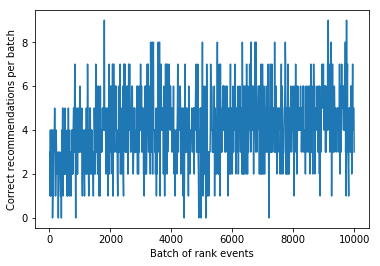

In [14]:
createChart(count, rewards) 

## Reading the chart

This chart shows the success of the current learning policy for the duration of the test. The ideal target that by the end of the test, the loop is averaging a success rate that is close to one hundred percent minus the exploration. The default setting of exploration is 20%. 

`100-20=80`

This exploration setting is found in the Azure portal, for the Personalizer resource, on the **Settings** page. 

In order to find a better learning policy, based on your data to the Rank API, run an [offline evaluation](how-to-offline-evaluation.md) in the portal for your Personalizer loop.

## Run an offline evaluation

1. In the Azure portal, open the Personalizer resource's **Evaluations** page.
1. Select **Create Evaluation**.
1. Enter the required data of evaluation name, and date range for the loop evaluation. The date range should include only the days you are focusing on for your evaluation. 

    The purpose of running this offline evaluation is to determine if there is a better learning policy for the features and actions used in this loop. To find that better learning policy, make sure **Optimization policy** is turned on.

1. Select **OK** to begin the evaluation. 
1. This **Evaluations** page lists the new evaluation and its current status. Depending on how much data you have, this evaluation can take some time. You can come back to this page after a few minutes to see the results. 
1. When the evaluation is completed, select the evaluation then select **Comparison of different learning policies**. This shows the available learning policies and how they would behave with the data. 
1. Select the top-most learning policy in the table and select **Apply**. This applies the _best_ learning policy to your model and retrains. 

## Change update model frequency to 5 minutes

1. In the Azure portal, still on the Personalizer resource, select the **Settings** page. 
1. Change the **model update frequency** and **reward wait time** to 5 minutes and select **Save**.

Learn more about the [reward wait time](https://docs.microsoft.com/en-us/azure/cognitive-services/personalizer/concept-rewards#reward-wait-time) and [model update frequency](https://docs.microsoft.com/en-us/azure/cognitive-services/personalizer/how-to-settings#model-update-frequency).

## Validate new learning policy by running experiment for 2,000 iterations

Return to the Azure notebook, and continue by running the same loop but for only 2,000 iterations. 

In [15]:
# max iterations
num_requests = 2000

# check last mod date N% of time - currently 10%
lastModCheck2 = int(num_requests * .10)

jsonTemplate2 = rankactionsjsonobj

# main iterations
[count2, rewards2] = iterations(num_requests, lastModCheck2, jsonTemplate2)

2019-10-01 16:42:49.727509
   1 None Cathy Rainy Afternoon Latte 1 
2019-10-01 16:42:50.312833
   2 None Bob Snowy Morning Cappucino 0 
2019-10-01 16:42:50.911096
   3 None Dave Rainy Evening Latte 1 
2019-10-01 16:42:51.514933
   4 None Dave Snowy Evening Cappucino 1 
2019-10-01 16:42:52.025588
   5 None Alice Sunny Evening Cold brew 1 
2019-10-01 16:42:52.595423
   6 None Dave Snowy Evening Cappucino 1 
2019-10-01 16:42:53.348246
   7 None Bob Rainy Evening Latte 1 
2019-10-01 16:42:53.852301
   8 None Dave Snowy Afternoon Iced mocha 0 
2019-10-01 16:42:54.351455
   9 None Bob Sunny Afternoon Iced mocha 1 
2019-10-01 16:42:54.876633
   10 None Bob Sunny Evening Cold brew 1 
2019-10-01 16:42:55.437823
   11 None Cathy Snowy Evening Cappucino 1 
2019-10-01 16:42:56.026608
   12 None Cathy Sunny Morning Cold brew 0 
2019-10-01 16:42:56.564728
   13 None Alice Sunny Afternoon Iced mocha 1 
2019-10-01 16:42:57.167612
   14 None Dave Rainy Evening Latte 1 
2019-10-01 16:42:57.678890
   15 

2019-10-01 16:43:59.283112
   118 None Dave Snowy Afternoon Iced mocha 0 
2019-10-01 16:43:59.795715
   119 None Dave Sunny Morning Cold brew 0 
2019-10-01 16:44:00.459751
   120 None Dave Snowy Evening Cappucino 1 
2019-10-01 16:44:00.999707
   121 None Alice Snowy Morning Cappucino 1 
2019-10-01 16:44:01.655923
   122 None Dave Snowy Morning Cappucino 1 
2019-10-01 16:44:02.334000
   123 None Bob Rainy Afternoon Latte 1 
2019-10-01 16:44:03.038638
   124 None Alice Sunny Afternoon Cold brew 0 
2019-10-01 16:44:03.875994
   125 None Bob Snowy Evening Cold brew 0 
2019-10-01 16:44:04.478665
   126 None Bob Sunny Morning Iced mocha 0 
2019-10-01 16:44:05.107242
   127 None Cathy Snowy Evening Cappucino 1 
2019-10-01 16:44:05.706787
   128 None Bob Snowy Morning Cold brew 0 
2019-10-01 16:44:06.250133
   129 None Cathy Sunny Morning Cold brew 0 
2019-10-01 16:44:06.784939
   130 None Bob Rainy Afternoon Latte 1 
2019-10-01 16:44:07.325542
   131 None Bob Snowy Afternoon Iced mocha 1 
201

2019-10-01 16:45:06.890546
   232 None Dave Rainy Afternoon Latte 1 
2019-10-01 16:45:07.448736
   233 None Cathy Sunny Morning Cold brew 0 
2019-10-01 16:45:07.947960
   234 None Bob Sunny Afternoon Iced mocha 1 
2019-10-01 16:45:08.500806
   235 None Bob Snowy Afternoon Iced mocha 1 
2019-10-01 16:45:09.034114
   236 None Alice Snowy Morning Cappucino 1 
2019-10-01 16:45:09.573567
   237 None Dave Rainy Evening Latte 1 
2019-10-01 16:45:10.165889
   238 None Cathy Sunny Morning Cold brew 0 
2019-10-01 16:45:10.732135
   239 None Dave Rainy Afternoon Latte 1 
2019-10-01 16:45:11.244660
   240 None Dave Sunny Evening Cappucino 0 
2019-10-01 16:45:11.762404
   241 None Cathy Rainy Evening Latte 0 
2019-10-01 16:45:12.354581
   242 None Alice Snowy Morning Iced mocha 0 
2019-10-01 16:45:12.858213
   243 None Alice Snowy Morning Cappucino 1 
2019-10-01 16:45:13.352534
   244 None Cathy Snowy Afternoon Iced mocha 1 
2019-10-01 16:45:13.882873
   245 None Bob Snowy Morning Latte 0 
2019-10-

2019-10-01 16:46:14.999972
   348 None Cathy Rainy Morning Latte 0 
2019-10-01 16:46:15.554497
   349 None Cathy Snowy Evening Cappucino 1 
2019-10-01 16:46:16.075112
   350 None Cathy Rainy Evening Latte 0 
2019-10-01 16:46:16.768040
   351 None Cathy Snowy Afternoon Iced mocha 1 
2019-10-01 16:46:17.365837
   352 None Cathy Sunny Morning Cappucino 0 
2019-10-01 16:46:17.941815
   353 None Alice Sunny Morning Cold brew 1 
2019-10-01 16:46:18.475918
   354 None Bob Rainy Evening Latte 1 
2019-10-01 16:46:18.979014
   355 None Dave Snowy Evening Cappucino 1 
2019-10-01 16:46:19.520898
   356 None Cathy Sunny Afternoon Iced mocha 0 
2019-10-01 16:46:23.108218
   357 None Alice Rainy Morning Latte 1 
2019-10-01 16:46:23.694459
   358 None Cathy Sunny Afternoon Iced mocha 0 
2019-10-01 16:46:24.297159
   359 None Alice Rainy Morning Latte 1 
2019-10-01 16:46:24.916725
   360 None Alice Rainy Morning Latte 1 
2019-10-01 16:46:25.432373
   361 None Bob Sunny Afternoon Iced mocha 1 
2019-10-0

2019-10-01 16:47:30.986233
   461 None Dave Rainy Afternoon Latte 1 
2019-10-01 16:47:31.544606
   462 None Alice Snowy Evening Cappucino 1 
2019-10-01 16:47:32.144653
   463 None Alice Rainy Afternoon Latte 0 
2019-10-01 16:47:32.677040
   464 None Alice Snowy Morning Cappucino 1 
2019-10-01 16:47:33.274958
   465 None Bob Rainy Afternoon Cappucino 0 
2019-10-01 16:47:33.967816
   466 None Cathy Snowy Evening Cappucino 1 
2019-10-01 16:47:34.798622
   467 None Cathy Snowy Morning Cappucino 0 
2019-10-01 16:47:35.516028
   468 None Bob Snowy Morning Cappucino 0 
2019-10-01 16:47:36.279464
   469 None Alice Sunny Afternoon Iced mocha 1 
2019-10-01 16:47:37.074073
   470 None Bob Rainy Afternoon Latte 1 
2019-10-01 16:47:37.761694
   471 None Cathy Sunny Morning Cold brew 0 
2019-10-01 16:47:38.469331
   472 None Cathy Rainy Evening Latte 0 
2019-10-01 16:47:39.150645
   473 None Dave Rainy Afternoon Latte 1 
2019-10-01 16:47:39.811547
   474 None Alice Rainy Morning Latte 1 
2019-10-01 

2019-10-01 16:48:44.906123
   577 None Bob Rainy Evening Latte 1 
2019-10-01 16:48:45.553960
   578 None Dave Snowy Evening Cold brew 0 
2019-10-01 16:48:46.414623
   579 None Bob Sunny Morning Cold brew 0 
2019-10-01 16:48:47.106546
   580 None Cathy Rainy Afternoon Latte 1 
2019-10-01 16:48:47.837243
   581 None Cathy Rainy Morning Latte 0 
2019-10-01 16:48:48.447848
   582 None Dave Rainy Morning Latte 1 
2019-10-01 16:48:49.052402
   583 None Bob Rainy Evening Latte 1 
2019-10-01 16:48:49.722626
   584 None Alice Sunny Evening Cold brew 1 
2019-10-01 16:48:50.394539
   585 None Dave Sunny Morning Iced mocha 1 
2019-10-01 16:48:50.941949
   586 None Cathy Rainy Morning Latte 0 
2019-10-01 16:48:51.514709
   587 None Cathy Sunny Afternoon Iced mocha 0 
2019-10-01 16:48:52.152515
   588 None Dave Sunny Evening Cappucino 0 
2019-10-01 16:48:52.749916
   589 None Dave Rainy Morning Latte 1 
2019-10-01 16:48:53.382387
   590 None Dave Sunny Afternoon Iced mocha 1 
2019-10-01 16:48:54.106

2019-10-01 16:49:52.652112
   691 None Alice Rainy Evening Latte 1 
2019-10-01 16:49:53.334171
   692 None Alice Sunny Afternoon Cold brew 0 
2019-10-01 16:49:53.921722
   693 None Dave Snowy Afternoon Iced mocha 0 
2019-10-01 16:49:54.657372
   694 None Dave Snowy Afternoon Cappucino 1 
2019-10-01 16:49:55.315278
   695 None Cathy Rainy Morning Latte 0 
2019-10-01 16:49:55.907475
   696 None Dave Sunny Afternoon Iced mocha 1 
2019-10-01 16:49:56.563617
   697 None Dave Rainy Afternoon Cold brew 0 
2019-10-01 16:49:57.132508
   698 None Cathy Rainy Evening Latte 0 
2019-10-01 16:49:57.683219
   699 None Dave Snowy Afternoon Latte 0 
2019-10-01 16:49:58.331597
   700 None Cathy Sunny Morning Cold brew 0 
2019-10-01 16:49:58.836054
   701 None Alice Rainy Evening Latte 1 
2019-10-01 16:49:59.409881
   702 None Dave Snowy Afternoon Iced mocha 0 
2019-10-01 16:50:00.040762
   703 None Dave Snowy Morning Cappucino 1 
2019-10-01 16:50:00.702282
   704 None Alice Snowy Evening Cappucino 1 
20

2019-10-01 16:50:59.684735
   804 None Bob Rainy Morning Latte 1 
2019-10-01 16:51:00.222689
   805 None Bob Sunny Evening Iced mocha 0 
2019-10-01 16:51:00.769714
   806 None Cathy Rainy Evening Latte 0 
2019-10-01 16:51:01.416010
   807 None Dave Sunny Afternoon Iced mocha 1 
2019-10-01 16:51:02.016923
   808 None Bob Snowy Evening Iced mocha 1 
2019-10-01 16:51:02.730828
   809 None Alice Sunny Afternoon Latte 0 
2019-10-01 16:51:03.424690
   810 None Cathy Rainy Morning Cold brew 0 
2019-10-01 16:51:04.063629
   811 None Dave Sunny Afternoon Iced mocha 1 
2019-10-01 16:51:04.656724
   812 None Cathy Rainy Evening Latte 0 
2019-10-01 16:51:05.191579
   813 None Cathy Snowy Afternoon Iced mocha 1 
2019-10-01 16:51:05.796596
   814 None Dave Snowy Morning Cappucino 1 
2019-10-01 16:51:06.419706
   815 None Dave Sunny Morning Iced mocha 1 
2019-10-01 16:51:06.940836
   816 None Dave Snowy Evening Latte 0 
2019-10-01 16:51:07.543078
   817 None Dave Rainy Morning Latte 1 
2019-10-01 16:

2019-10-01 16:52:08.097685
   920 None Dave Rainy Evening Cappucino 0 
2019-10-01 16:52:08.791212
   921 None Cathy Sunny Afternoon Iced mocha 0 
2019-10-01 16:52:09.470455
   922 None Alice Sunny Evening Cold brew 1 
2019-10-01 16:52:10.038194
   923 None Bob Sunny Evening Latte 0 
2019-10-01 16:52:10.542498
   924 None Alice Sunny Evening Iced mocha 0 
2019-10-01 16:52:11.141216
   925 None Bob Sunny Morning Iced mocha 0 
2019-10-01 16:52:11.666119
   926 None Alice Rainy Evening Cappucino 0 
2019-10-01 16:52:12.216485
   927 None Cathy Snowy Afternoon Cappucino 0 
2019-10-01 16:52:12.747380
   928 None Cathy Sunny Morning Cold brew 0 
2019-10-01 16:52:13.274812
   929 None Dave Rainy Morning Latte 1 
2019-10-01 16:52:13.803836
   930 None Cathy Rainy Evening Iced mocha 1 
2019-10-01 16:52:14.327158
   931 None Bob Rainy Morning Latte 1 
2019-10-01 16:52:14.927107
   932 None Dave Snowy Morning Cappucino 1 
2019-10-01 16:52:15.487566
   933 None Cathy Snowy Evening Cappucino 1 
2019-

2019-10-01 16:53:14.778763
   1032 None Alice Snowy Evening Cappucino 1 
2019-10-01 16:53:15.342015
   1033 None Cathy Rainy Morning Latte 0 
2019-10-01 16:53:15.909776
   1034 None Bob Rainy Morning Latte 1 
2019-10-01 16:53:16.497942
   1035 None Alice Sunny Morning Cold brew 1 
2019-10-01 16:53:17.146784
   1036 None Cathy Rainy Afternoon Latte 1 
2019-10-01 16:53:17.774441
   1037 None Dave Sunny Evening Iced mocha 1 
2019-10-01 16:53:18.373758
   1038 None Alice Snowy Evening Cold brew 0 
2019-10-01 16:53:18.971056
   1039 None Alice Rainy Morning Cappucino 0 
2019-10-01 16:53:19.545768
   1040 None Dave Sunny Afternoon Iced mocha 1 
2019-10-01 16:53:20.136697
   1041 None Bob Sunny Morning Iced mocha 0 
2019-10-01 16:53:20.757647
   1042 None Bob Sunny Morning Iced mocha 0 
2019-10-01 16:53:21.294432
   1043 None Alice Sunny Evening Cappucino 0 
2019-10-01 16:53:21.959227
   1044 None Cathy Sunny Morning Latte 1 
2019-10-01 16:53:22.806901
   1045 None Alice Sunny Afternoon Iced 

2019-10-01 16:54:21.905862
   1146 None Alice Sunny Afternoon Cold brew 0 
2019-10-01 16:54:22.481430
   1147 None Alice Rainy Evening Latte 1 
2019-10-01 16:54:23.118609
   1148 None Bob Snowy Morning Iced mocha 1 
2019-10-01 16:54:23.835148
   1149 None Alice Rainy Morning Latte 1 
2019-10-01 16:54:24.409492
   1150 None Bob Sunny Evening Iced mocha 0 
2019-10-01 16:54:24.986878
   1151 None Alice Snowy Evening Cappucino 1 
2019-10-01 16:54:25.547471
   1152 None Bob Sunny Evening Iced mocha 0 
2019-10-01 16:54:26.079428
   1153 None Alice Rainy Morning Latte 1 
2019-10-01 16:54:26.584420
   1154 None Cathy Sunny Afternoon Iced mocha 0 
2019-10-01 16:54:27.241457
   1155 None Cathy Snowy Afternoon Iced mocha 1 
2019-10-01 16:54:27.856052
   1156 None Alice Snowy Afternoon Cappucino 1 
2019-10-01 16:54:28.522921
   1157 None Bob Sunny Morning Iced mocha 0 
2019-10-01 16:54:29.129375
   1158 None Alice Snowy Morning Cappucino 1 
2019-10-01 16:54:29.674507
   1159 None Dave Sunny Mornin

2019-10-01 16:55:57.927595
   1296 None Bob Sunny Morning Iced mocha 0 
2019-10-01 16:55:58.568375
   1297 None Bob Snowy Evening Iced mocha 1 
2019-10-01 16:55:59.125450
   1298 None Alice Sunny Evening Cold brew 1 
2019-10-01 16:55:59.784230
   1299 None Bob Rainy Afternoon Latte 1 
2019-10-01 16:56:00.507047
   1300 None Bob Rainy Evening Iced mocha 0 
2019-10-01 16:56:01.682705
   1301 None Dave Sunny Afternoon Iced mocha 1 
2019-10-01 16:56:02.596190
   1302 None Dave Sunny Morning Iced mocha 1 
2019-10-01 16:56:03.203943
   1303 None Cathy Rainy Evening Latte 0 
2019-10-01 16:56:03.942786
   1304 None Cathy Sunny Evening Cold brew 0 
2019-10-01 16:56:04.598239
   1305 None Bob Sunny Evening Iced mocha 0 
2019-10-01 16:56:05.149584
   1306 None Cathy Rainy Evening Latte 0 
2019-10-01 16:56:05.722923
   1307 None Cathy Snowy Evening Cappucino 1 
2019-10-01 16:56:06.521571
   1308 None Bob Sunny Morning Iced mocha 0 
2019-10-01 16:56:07.312809
   1309 None Dave Snowy Morning Latte 0

2019-10-01 16:57:09.971182
   1408 None Dave Snowy Morning Cappucino 1 
2019-10-01 16:57:10.623035
   1409 None Alice Rainy Afternoon Cold brew 0 
2019-10-01 16:57:11.230781
   1410 None Cathy Sunny Evening Cold brew 0 
2019-10-01 16:57:11.886149
   1411 None Bob Sunny Evening Iced mocha 0 
2019-10-01 16:57:12.615643
   1412 None Dave Sunny Afternoon Iced mocha 1 
2019-10-01 16:57:13.188799
   1413 None Alice Sunny Evening Cold brew 1 
2019-10-01 16:57:13.754047
   1414 None Cathy Sunny Afternoon Iced mocha 0 
2019-10-01 16:57:14.305202
   1415 None Cathy Sunny Morning Cold brew 0 
2019-10-01 16:57:14.871669
   1416 None Dave Sunny Evening Iced mocha 1 
2019-10-01 16:57:15.541633
   1417 None Alice Snowy Morning Cappucino 1 
2019-10-01 16:57:16.098099
   1418 None Bob Sunny Afternoon Iced mocha 1 
2019-10-01 16:57:16.836944
   1419 None Dave Sunny Afternoon Latte 0 
2019-10-01 16:57:17.417079
   1420 None Bob Sunny Evening Iced mocha 0 
2019-10-01 16:57:17.982555
   1421 None Bob Rainy

2019-10-01 16:58:19.976434
   1522 None Alice Sunny Morning Cold brew 1 
2019-10-01 16:58:20.660770
   1523 None Bob Rainy Afternoon Latte 1 
2019-10-01 16:58:21.297339
   1524 None Bob Rainy Afternoon Cappucino 0 
2019-10-01 16:58:21.903160
   1525 None Alice Rainy Afternoon Latte 0 
2019-10-01 16:58:22.703231
   1526 None Cathy Sunny Evening Cold brew 0 
2019-10-01 16:58:23.282661
   1527 None Alice Snowy Evening Cappucino 1 
2019-10-01 16:58:23.935886
   1528 None Bob Snowy Evening Iced mocha 1 
2019-10-01 16:58:24.497023
   1529 None Cathy Snowy Morning Cappucino 0 
2019-10-01 16:58:25.013691
   1530 None Alice Snowy Morning Cappucino 1 
2019-10-01 16:58:25.535043
   1531 None Alice Snowy Morning Cappucino 1 
2019-10-01 16:58:26.072378
   1532 None Alice Sunny Morning Iced mocha 0 
2019-10-01 16:58:26.609617
   1533 None Cathy Snowy Afternoon Iced mocha 1 
2019-10-01 16:58:27.224756
   1534 None Bob Snowy Afternoon Iced mocha 1 
2019-10-01 16:58:27.884528
   1535 None Cathy Sunny M

2019-10-01 16:59:28.903569
   1633 None Cathy Sunny Morning Iced mocha 0 
2019-10-01 16:59:29.511043
   1634 None Dave Snowy Morning Cappucino 1 
2019-10-01 16:59:30.092781
   1635 None Cathy Sunny Morning Cold brew 0 
2019-10-01 16:59:30.639253
   1636 None Dave Snowy Afternoon Iced mocha 0 
2019-10-01 16:59:31.179850
   1637 None Alice Sunny Morning Cold brew 1 
2019-10-01 16:59:31.750924
   1638 None Alice Rainy Afternoon Latte 0 
2019-10-01 16:59:32.425972
   1639 None Alice Sunny Morning Cold brew 1 
2019-10-01 16:59:33.134169
   1640 None Alice Sunny Evening Cold brew 1 
2019-10-01 16:59:33.727101
   1641 None Bob Sunny Morning Iced mocha 0 
2019-10-01 16:59:34.397434
   1642 None Alice Snowy Afternoon Cappucino 1 
2019-10-01 16:59:35.130558
   1643 None Dave Rainy Morning Latte 1 
2019-10-01 16:59:35.759455
   1644 None Dave Rainy Evening Latte 1 
2019-10-01 16:59:36.602716
   1645 None Cathy Rainy Evening Latte 0 
2019-10-01 16:59:37.226545
   1646 None Cathy Snowy Morning Capp

2019-10-01 17:00:40.486571
   1747 None Alice Snowy Afternoon Cappucino 1 
2019-10-01 17:00:41.089614
   1748 None Alice Snowy Evening Cappucino 1 
2019-10-01 17:00:41.776955
   1749 None Dave Rainy Afternoon Latte 1 
2019-10-01 17:00:42.527100
   1750 None Cathy Snowy Evening Cold brew 0 
2019-10-01 17:00:43.248296
   1751 None Dave Sunny Evening Iced mocha 1 
2019-10-01 17:00:44.019763
   1752 None Bob Snowy Evening Iced mocha 1 
2019-10-01 17:00:44.809567
   1753 None Alice Sunny Afternoon Cold brew 0 
2019-10-01 17:00:45.503780
   1754 None Dave Rainy Morning Latte 1 
2019-10-01 17:00:46.244261
   1755 None Cathy Rainy Evening Latte 0 
2019-10-01 17:00:46.948612
   1756 None Cathy Snowy Afternoon Iced mocha 1 
2019-10-01 17:00:47.690205
   1757 None Dave Snowy Evening Cappucino 1 
2019-10-01 17:00:48.426316
   1758 None Bob Rainy Evening Latte 1 
2019-10-01 17:00:49.123213
   1759 None Cathy Snowy Evening Cold brew 0 
2019-10-01 17:00:50.006661
   1760 None Cathy Snowy Morning Iced

2019-10-01 17:01:49.752796
   1859 None Cathy Sunny Morning Iced mocha 0 
2019-10-01 17:01:50.289018
   1860 None Bob Snowy Morning Iced mocha 1 
2019-10-01 17:01:50.879600
   1861 None Bob Sunny Afternoon Iced mocha 1 
2019-10-01 17:01:51.396553
   1862 None Alice Rainy Morning Latte 1 
2019-10-01 17:01:52.006157
   1863 None Alice Sunny Evening Cold brew 1 
2019-10-01 17:01:52.541537
   1864 None Cathy Sunny Afternoon Iced mocha 0 
2019-10-01 17:01:53.178183
   1865 None Dave Sunny Evening Cappucino 0 
2019-10-01 17:01:53.713948
   1866 None Dave Rainy Afternoon Latte 1 
2019-10-01 17:01:54.342125
   1867 None Dave Snowy Morning Cappucino 1 
2019-10-01 17:01:54.853921
   1868 None Dave Sunny Morning Iced mocha 1 
2019-10-01 17:01:55.387119
   1869 None Dave Sunny Morning Iced mocha 1 
2019-10-01 17:01:55.946223
   1870 None Bob Sunny Afternoon Iced mocha 1 
2019-10-01 17:01:56.486234
   1871 None Alice Rainy Evening Cappucino 0 
2019-10-01 17:01:57.038868
   1872 None Alice Snowy Eve

2019-10-01 17:02:54.537117
   1973 None Cathy Sunny Evening Cold brew 0 
2019-10-01 17:02:55.199797
   1974 None Dave Sunny Morning Iced mocha 1 
2019-10-01 17:02:55.778883
   1975 None Bob Snowy Morning Iced mocha 1 
2019-10-01 17:02:56.339169
   1976 None Alice Sunny Afternoon Cappucino 0 
2019-10-01 17:02:56.907855
   1977 None Bob Sunny Evening Cold brew 1 
2019-10-01 17:02:57.413378
   1978 None Dave Sunny Afternoon Iced mocha 1 
2019-10-01 17:02:57.904682
   1979 None Dave Snowy Evening Cold brew 0 
2019-10-01 17:02:58.485414
   1980 None Dave Rainy Morning Latte 1 
2019-10-01 17:02:59.014306
   1981 None Bob Snowy Morning Iced mocha 1 
2019-10-01 17:02:59.587473
   1982 None Alice Sunny Afternoon Cold brew 0 
2019-10-01 17:03:00.194257
   1983 None Alice Rainy Morning Iced mocha 0 
2019-10-01 17:03:00.706934
   1984 None Cathy Rainy Afternoon Latte 1 
2019-10-01 17:03:01.210896
   1985 None Alice Sunny Morning Cold brew 1 
2019-10-01 17:03:01.738537
   1986 None Cathy Rainy Even

## Run chart for 2,000 rank requests

Run the `createChart` function.

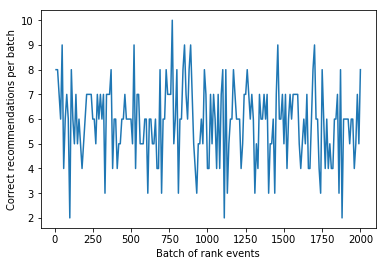

In [16]:
createChart(count2,rewards2)


## Review the second chart

The second chart should show a visible increase in Rank predictions aligning with user preferences. 

## Clean up resources

If you do not intend to continue the tutorial series, clean up the following resources:

* Delete your Azure Notebook project. 
* Delete your Personalizer resource. 